# Statystyka stosowana - Raport 2  
**Emil Olszewski**

## Testowanie hipotez statystycznych

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import pandas as pd 

In [151]:
plt.style.use("seaborn-v0_8-notebook")

In [18]:
"""
    Funkcja zwracająca dane ze strony www.
"""
def load_data(path: str):

    df: pd.DataFrame = pd.read_csv(path, header=None)
    return np.array(df[0])
    

In [273]:
"""
    Funkcja tworząca wykres zbiorów krytycznych danego testu
"""
def plot_test(
        z,                  # statystyka testowa
        lower_bound=None,   # dolna wartość krytyczna
        upper_bound=None,   # górna wartość krytyczna
        dist=st.norm       # rozkład z jakiego pochodzi statystyka
):
    
    lo, hi = dist.ppf(0.001), dist.ppf(0.999)  # Zakres osi X
    xs = np.arange(lo, hi, 0.1)
    ys = dist.pdf(xs)
    p = plt.plot(xs, ys, label="Gęstość N(0, 1)" if dist == st.norm else "Gęstość Chi^2(999)")

    if lower_bound:
        plt.plot(
            [lower_bound, lower_bound],
            [0, dist.pdf(lower_bound)],
            c="red"
        )
        plt.fill_between(
            np.arange(lo, lower_bound + 0.1, 0.1),
            0,
            dist.pdf(np.arange(lo, lower_bound + 0.1, 0.1)),
            facecolor="red", 
            label="Zbiór krytyczny"
        )

    if upper_bound:
        plt.plot(
            [upper_bound, upper_bound],
            [0, dist.pdf(upper_bound)],
            c="red"
        )
        plt.fill_between(
            np.arange(upper_bound, hi, 0.1),
            0,
            dist.pdf(np.arange(upper_bound, hi, 0.1)),
            facecolor="red",
            label=None if lower_bound else "Zbiór krytyczny"
        )
        
    if lo <= z <= hi:
        plt.plot(
            [z, z],
            [0, dist.pdf(z)],
            c="orange",
            label="Statystyka testowa"
        )
    
    plt.grid(True)
    plt.legend()
    plt.xlim(lo, hi)

    return p

### Zadanie 1

In [211]:
data1 = load_data("http://prac.im.pwr.edu.pl/~wyloman/ss_2022_2023/lista8_zad1.txt")

In [274]:
def test_for_mean(
        mean,                    # wartość oczekiwana rozkładu przy założeniu hipotezy zerowej
        std,                     # odchylenie standardowe rozkładu (znane)
        alfa,                    # poziom istotności testu
        sample,                  # testowana próbka
        alternative="not_equal"  # hipoteza alterantywna
):

    # Statystyka testowa, posiadająca rozkład N(0, 1) przy założeniu prawdziwości H0
    z = (np.mean(sample) - mean) * np.sqrt(len(sample)) / std
    dist = st.norm

    if alternative == "not_equal":
        lower_bound = dist.ppf(alfa/2)
        upper_bound = -lower_bound          # Ze względu na symetryczność rozkładu N(0, 1) kwantyl rzędu a/2 to -1 * kwantyl rzędu 1 - a/2
    elif alternative == "less":
        lower_bound = dist.ppf(alfa)
        upper_bound = None
    elif alternative == "greater":
        lower_bound = None
        upper_bound = dist.ppf(1 - alfa)
    else:
        raise Exception("Podano nieprawidłową hipotezę alternatywną")


    # p-wartość 

    # p-wartość to taka wartość poziomu istotności testu statystycznego, że
    # statystyka testowa równa się wartości krytycznej testu.

    if alternative == "not_equal": 
        if z >= 0:
            pvalue = 2 * (1 - dist.cdf(z))
        else:
            pvalue = 2 * dist.cdf(z)
    elif alternative == "less":
        pvalue = dist.cdf(z)
    else:
        pvalue = 1 - dist.cdf(z)

    alt_hypo = "mu != 1.5" if alternative == "not_equal" else (
               "mu < 1.5" if alternative == "less" else "mu > 1.5"
    )

    print(f"p-wartość (dla H1: {alt_hypo}): {pvalue}")

    return plot_test(z, lower_bound, upper_bound, dist=dist)

p-wartość (dla H1: mu != 1.5): 1.902482582482688e-12


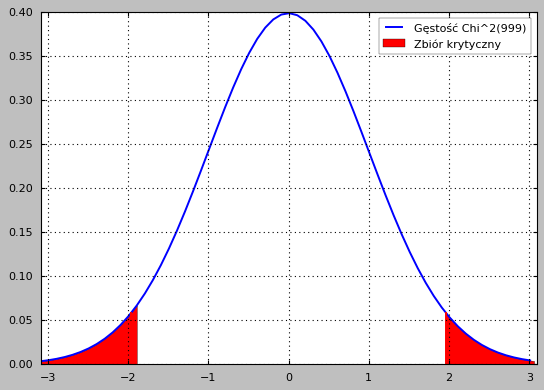

In [275]:
plt.show(test_for_mean(1.5, 0.2, 0.05, data1, alternative="not_equal"))

p-wartość (dla H1: mu < 1.5): 9.51241291241344e-13


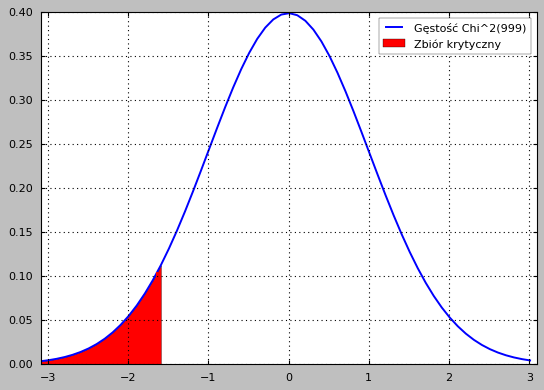

In [267]:
plt.show(test_for_mean(1.5, 0.2, 0.05, data1, alternative="less"))

p-wartość (dla H1: mu > 1.5): 0.9999999999990488


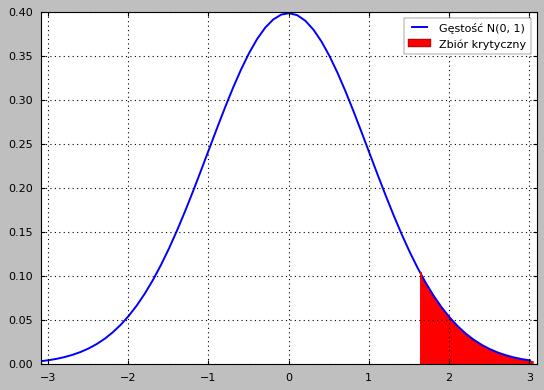

In [219]:
plt.show(test_for_mean(1.5, 0.2, 0.05, data1, alternative="greater"))

### Zadanie 2

In [169]:
data2 = load_data("http://prac.im.pwr.edu.pl/~wyloman/ss_2022_2023/lista8_zad2.txt")
len(data2)

1000

In [256]:
def test_for_var(
        var,                     # wariancja rozkładu przy założeniu hipotezy zerowej
        alfa,                    # poziom istotności testu
        sample,                  # testowana próbka
        alternative="not_equal"  # hipoteza alterantywna
):
        
    # Statystyka testowa (rozkład Chi^2)
    z = (len(sample) - 1) * np.var(sample) / var
    dist = st.chi2(len(sample) - 1)

    
    if alternative == "not_equal":
        lower_bound = dist.ppf(alfa/2)
        upper_bound = dist.ppf(1 - alfa/2)         
    elif alternative == "less":
        lower_bound = dist.ppf(alfa)
        upper_bound = None
    elif alternative == "greater":
        lower_bound = None
        upper_bound = dist.ppf(1 - alfa)
    else:
        raise Exception("Podano nieprawidłową hipotezę alternatywną")    
    
    
    # p-wartość

    if alternative == "not_equal":
        if z >= (len(sample) - 1):
            pvalue = 2 * (1 - dist.cdf(z))
        else:
            pvalue = 2 * dist.cdf(z)
    elif alternative == "less":
        pvalue = dist.cdf(z)
    else:
        pvalue = 1 - dist.cdf(z)
        

    alt_hypo = "simga^2 != 1.5" if alternative == "not_equal" else (
               "sigma^2 < 1.5" if alternative == "less" else "sigma^2 > 1.5"
    )

    print(f"p-wartość (dla H1: {alt_hypo}): {pvalue}")


    return plot_test(z, lower_bound, upper_bound, dist=dist)
    
    

p-wartość (dla H1: mu != 1.5): 0.016011673877854404
1109.8574804526054


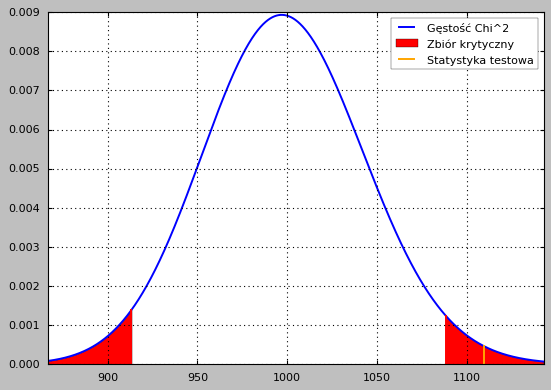

In [254]:
plt.show(test_for_var(1.5, 0.05, data2, alternative="not_equal"))

p-wartość (dla H1: sigma^2 < 1.5): 0.9919941630610728


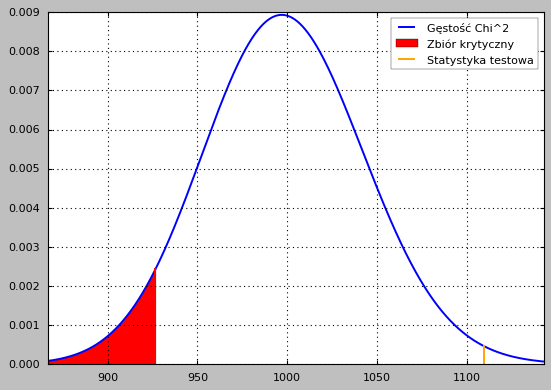

In [257]:
plt.show(test_for_var(1.5, 0.05, data2, alternative="less"))

p-wartość (dla H1: sigma^2 > 1.5): 0.008005836938927202


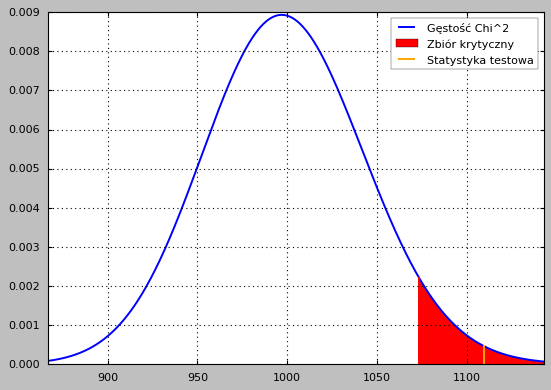

In [259]:
plt.show(test_for_var(1.5, 0.05, data2, alternative="greater"))

In [272]:
d = st.norm
d == st.norm

False